# 🦷 Dental Implant 10-Year Survival Prediction

## Notebook 06: CatBoost Model

**Objective:** Train and evaluate a CatBoost classifier - a gradient boosting algorithm that handles categorical features natively.

---


### 🎨 Setup: Import Libraries & Configure Plotting


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Periospot Brand Colors
COLORS = {
    'periospot_blue': '#15365a',
    'mystic_blue': '#003049',
    'periospot_red': '#6c1410',
    'crimson_blaze': '#a92a2a',
    'vanilla_cream': '#f7f0da',
    'black': '#000000',
    'white': '#ffffff',
    'classic_periospot_blue': '#0031af',
    'periospot_light_blue': '#0297ed',
    'periospot_dark_blue': '#02011e',
    'periospot_yellow': '#ffc430',
    'periospot_bright_blue': '#1040dd'
}

periospot_palette = [COLORS['periospot_blue'], COLORS['crimson_blaze'], 
                     COLORS['periospot_light_blue'], COLORS['periospot_yellow']]

# Configure matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.facecolor'] = COLORS['white']
plt.rcParams['axes.facecolor'] = COLORS['vanilla_cream']
plt.rcParams['axes.edgecolor'] = COLORS['periospot_blue']

sns.set_palette(periospot_palette)

print("✅ Libraries imported and plotting style configured!")


✅ Libraries imported and plotting style configured!


---

### 1. Load Processed Data & Setup


In [15]:
# =============================================================================
# LOAD CATBOOST-SPECIFIC DATA (with categorical columns as strings)
# =============================================================================

# Load features and target
X = pd.read_csv('../data/processed/catboost/X_train_catboost.csv')
y = pd.read_csv('../data/processed/catboost/y_train_catboost.csv').values.ravel()

# IMPORTANT: Load the list of categorical columns!
# CatBoost needs to know which columns are categorical
cat_features = pd.read_csv('../data/processed/catboost/categorical_columns.csv')['categorical_columns'].tolist()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\n🐱 Categorical columns for CatBoost ({len(cat_features)}):")
for col in cat_features:
    print(f"   - {col}: {X[col].dtype} → {X[col].nunique()} unique values")

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")


X shape: (7000, 22)
y shape: (7000,)

🐱 Categorical columns for CatBoost (6):
   - gender: object → 2 unique values
   - jaw_location: object → 2 unique values
   - implant_surface: object → 4 unique values
   - placement_timing: object → 3 unique values
   - loading_protocol: object → 3 unique values
   - restoration_type: object → 3 unique values

Training set: 5600 samples
Validation set: 1400 samples


---

### 2. Train CatBoost Model

CatBoost (Categorical Boosting) is a gradient boosting algorithm that handles categorical features natively and often requires less tuning.


In [16]:
# =============================================================================
# CATBOOST WITHOUT CLASS WEIGHTS (Baseline - will likely have 0% failure recall)
# =============================================================================

cat_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=False,
    cat_features=cat_features  # ← CRITICAL: Tell CatBoost which columns are categorical!
)

cat_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
print("✅ CatBoost (no weights) model trained!")

# =============================================================================
# CATBOOST WITH CLASS IMBALANCE HANDLING
# =============================================================================
# CatBoost has 'auto_class_weights' parameter:
# - 'Balanced': Automatically compute weights inversely proportional to class frequencies
# - 'SqrtBalanced': Square root of Balanced weights (less aggressive)

cat_balanced = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=False,
    cat_features=cat_features,
    auto_class_weights='Balanced'  # ← KEY PARAMETER FOR CLASS IMBALANCE!
)

cat_balanced.fit(X_train, y_train, eval_set=[(X_val, y_val)])
print("✅ CatBoost (auto_class_weights='Balanced') model trained!")


✅ CatBoost (no weights) model trained!
✅ CatBoost (auto_class_weights='Balanced') model trained!


---

### 3. Evaluate CatBoost Model


In [17]:
# =============================================================================
# COMPARE BOTH MODELS
# =============================================================================
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, recall_score

# ---- Model 1: CatBoost (no weights) ----
y_pred_cat = cat_model.predict(X_val)
y_pred_cat_proba = cat_model.predict_proba(X_val)[:, 1]

roc_auc_cat = roc_auc_score(y_val, y_pred_cat_proba)
pr_auc_cat = average_precision_score(y_val, y_pred_cat_proba)
accuracy_cat = accuracy_score(y_val, y_pred_cat)
f1_macro_cat = f1_score(y_val, y_pred_cat, average='macro')
recall_failure_cat = recall_score(y_val, y_pred_cat, pos_label=0)
recall_survival_cat = recall_score(y_val, y_pred_cat, pos_label=1)

print("=" * 70)
print("CatBoost (NO WEIGHTS) - Will predict everything as survival!")
print("=" * 70)
print(f"  ROC-AUC:           {roc_auc_cat:.4f}")
print(f"  PR-AUC:            {pr_auc_cat:.4f}")
print(f"  Accuracy:          {accuracy_cat:.4f}")
print(f"  F1 (Macro):        {f1_macro_cat:.4f}")
print(f"  Recall (Failure):  {recall_failure_cat:.4f} <- Problem: likely 0%!")
print(f"  Recall (Survival): {recall_survival_cat:.4f}")

# ---- Model 2: CatBoost (balanced) ----
y_pred_balanced = cat_balanced.predict(X_val)
y_pred_balanced_proba = cat_balanced.predict_proba(X_val)[:, 1]

roc_auc_balanced = roc_auc_score(y_val, y_pred_balanced_proba)
pr_auc_balanced = average_precision_score(y_val, y_pred_balanced_proba)
accuracy_balanced = accuracy_score(y_val, y_pred_balanced)
f1_macro_balanced = f1_score(y_val, y_pred_balanced, average='macro')
recall_failure_balanced = recall_score(y_val, y_pred_balanced, pos_label=0)
recall_survival_balanced = recall_score(y_val, y_pred_balanced, pos_label=1)

print("\n" + "=" * 70)
print("CatBoost (auto_class_weights='Balanced') - Should detect some failures!")
print("=" * 70)
print(f"  ROC-AUC:           {roc_auc_balanced:.4f}")
print(f"  PR-AUC:            {pr_auc_balanced:.4f}")
print(f"  Accuracy:          {accuracy_balanced:.4f}")
print(f"  F1 (Macro):        {f1_macro_balanced:.4f}")
print(f"  Recall (Failure):  {recall_failure_balanced:.4f} <- Should be > 0%!")
print(f"  Recall (Survival): {recall_survival_balanced:.4f}")


CatBoost (NO WEIGHTS) - Will predict everything as survival!
  ROC-AUC:           0.5924
  PR-AUC:            0.9369
  Accuracy:          0.9093
  F1 (Macro):        0.4762
  Recall (Failure):  0.0000 <- Problem: likely 0%!
  Recall (Survival): 1.0000

CatBoost (auto_class_weights='Balanced') - Should detect some failures!
  ROC-AUC:           0.6088
  PR-AUC:            0.9373
  Accuracy:          0.6300
  F1 (Macro):        0.4822
  Recall (Failure):  0.5276 <- Should be > 0%!
  Recall (Survival): 0.6402


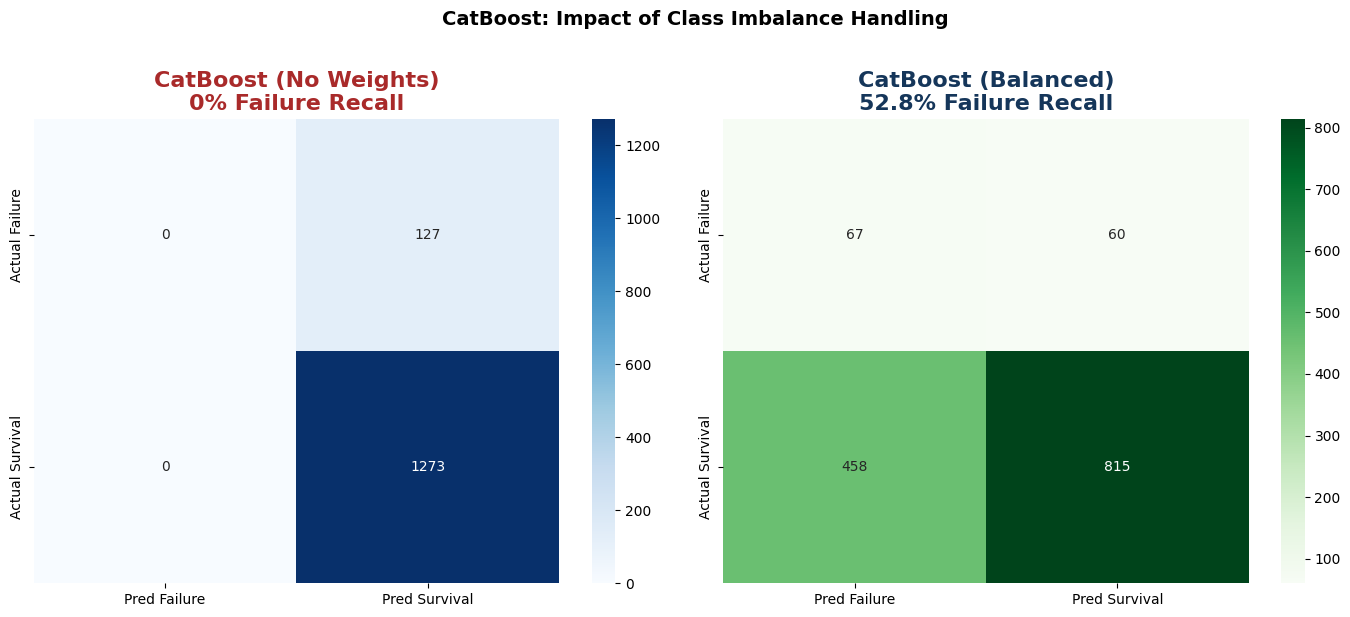


Classification Report (CatBoost Balanced):
              precision    recall  f1-score   support

           0       0.13      0.53      0.21       127
           1       0.93      0.64      0.76      1273

    accuracy                           0.63      1400
   macro avg       0.53      0.58      0.48      1400
weighted avg       0.86      0.63      0.71      1400



In [18]:
# =============================================================================
# SIDE-BY-SIDE CONFUSION MATRICES
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ---- Left: No Weights ----
cm_no_weights = confusion_matrix(y_val, y_pred_cat)
sns.heatmap(cm_no_weights, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred Failure', 'Pred Survival'],
            yticklabels=['Actual Failure', 'Actual Survival'])
axes[0].set_title(f'CatBoost (No Weights)\n{recall_failure_cat*100:.0f}% Failure Recall', 
                  fontweight='bold', color=COLORS['crimson_blaze'])

# ---- Right: With Balanced Weights ----
cm_balanced = confusion_matrix(y_val, y_pred_balanced)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Pred Failure', 'Pred Survival'],
            yticklabels=['Actual Failure', 'Actual Survival'])
axes[1].set_title(f'CatBoost (Balanced)\n{recall_failure_balanced*100:.1f}% Failure Recall', 
                  fontweight='bold', color=COLORS['periospot_blue'])

plt.suptitle('CatBoost: Impact of Class Imbalance Handling', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/cat_balanced_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nClassification Report (CatBoost Balanced):")
print(classification_report(y_val, y_pred_balanced))


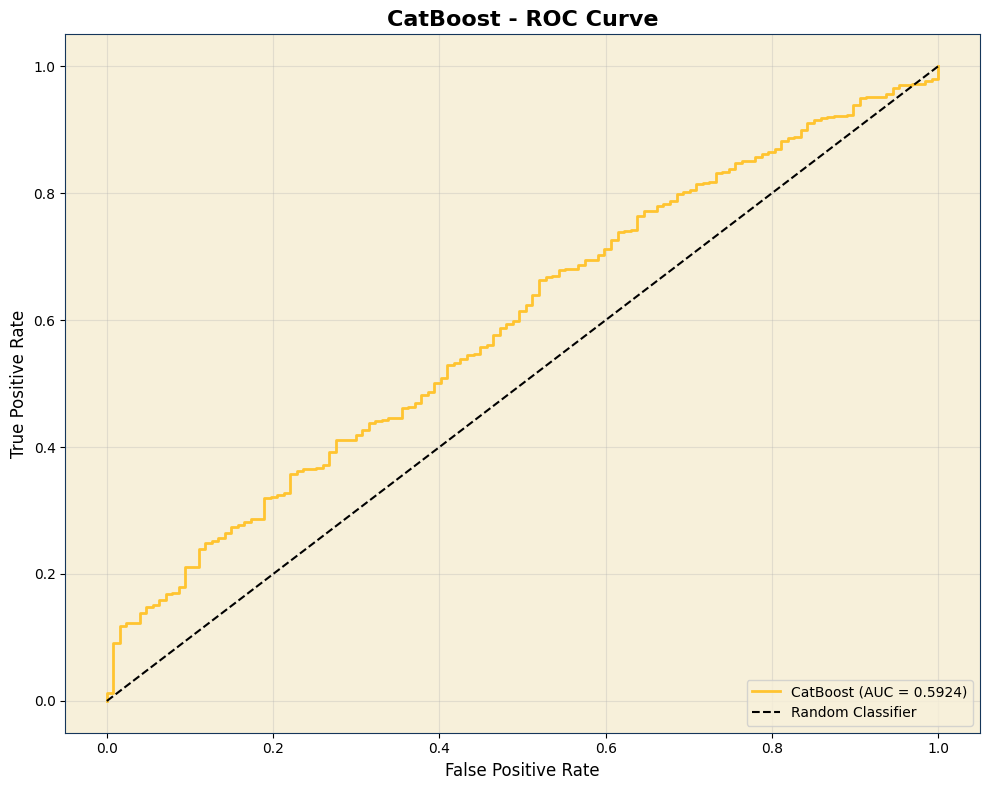

In [19]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(10, 8))

fpr, tpr, _ = roc_curve(y_val, y_pred_cat_proba)
ax.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc_cat:.4f})', 
        color=COLORS['periospot_yellow'], linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('CatBoost - ROC Curve', fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/cat_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()


---

### 4. Feature Importance Analysis


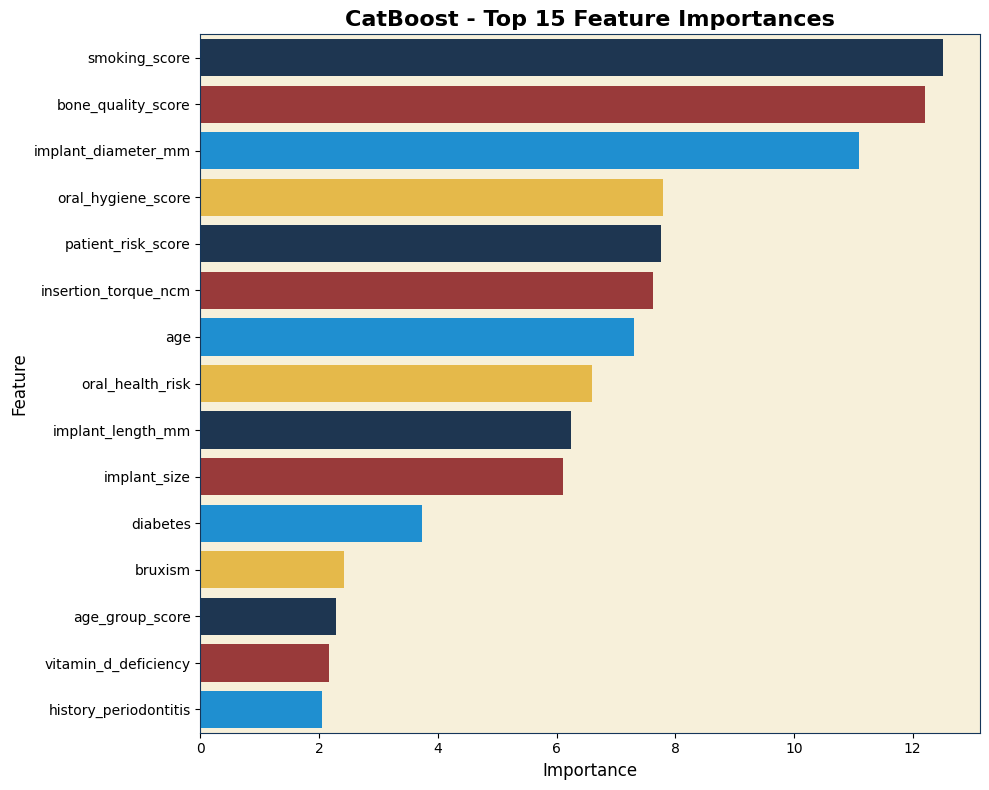


Top 10 Most Important Features:
             feature  importance
       smoking_score   12.507535
  bone_quality_score   12.212680
 implant_diameter_mm   11.087967
  oral_hygiene_score    7.790635
  patient_risk_score    7.758889
insertion_torque_ncm    7.618858
                 age    7.307269
    oral_health_risk    6.592350
   implant_length_mm    6.249492
        implant_size    6.112979


In [20]:
# TODO: Visualize feature importance from CatBoost.

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': cat_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', 
            palette=periospot_palette, ax=ax)
ax.set_title('CatBoost - Top 15 Feature Importances', fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig('../figures/cat_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))


---

### 🔧 Optuna Hyperparameter Tuning

Now let's use **Optuna** to find the best hyperparameters for CatBoost, optimizing for F1-Macro (which balances both classes equally).

**Key parameters to tune:**
- `iterations`: Number of boosting rounds
- `depth`: Maximum tree depth
- `learning_rate`: Step size shrinkage
- `l2_leaf_reg`: L2 regularization
- `bagging_temperature`: Controls bootstrap sampling
- `auto_class_weights`: Balanced vs SqrtBalanced


In [21]:
import optuna
from sklearn.model_selection import cross_val_score

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """
    Optuna objective function for CatBoost hyperparameter optimization.
    Goal: Maximize F1 (Macro) score using cross-validation.
    """
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        'random_state': 42,
        'verbose': False,
        'cat_features': cat_features
    }
    
    model = CatBoostClassifier(**params)
    
    # Use 3-fold cross-validation with F1 Macro scoring
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_macro', n_jobs=-1)
    
    return scores.mean()

# Create and run the study
print("🔍 Starting Optuna hyperparameter search for CatBoost...")
print("   Optimizing F1 (Macro) with 50 trials...")
print("   This may take a few minutes...\n")

study = optuna.create_study(direction='maximize', study_name='catboost_tuning')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "=" * 70)
print("OPTUNA OPTIMIZATION COMPLETE!")
print("=" * 70)
print(f"Best F1 (Macro) Score: {study.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


🔍 Starting Optuna hyperparameter search for CatBoost...
   Optimizing F1 (Macro) with 50 trials...
   This may take a few minutes...



  0%|          | 0/50 [00:00<?, ?it/s]


OPTUNA OPTIMIZATION COMPLETE!
Best F1 (Macro) Score: 0.5270

Best Hyperparameters:
  iterations: 205
  depth: 8
  learning_rate: 0.0474081228520346
  l2_leaf_reg: 8.175656292906874
  bagging_temperature: 0.5207454799668334
  auto_class_weights: Balanced


In [22]:
# =============================================================================
# TRAIN CATBOOST WITH BEST OPTUNA PARAMETERS
# =============================================================================

best_params = study.best_params.copy()
best_params['random_state'] = 42
best_params['verbose'] = False
best_params['cat_features'] = cat_features

cat_optimized = CatBoostClassifier(**best_params)
cat_optimized.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Predictions
y_pred_opt = cat_optimized.predict(X_val)
y_pred_opt_proba = cat_optimized.predict_proba(X_val)[:, 1]

# Metrics
roc_auc_opt = roc_auc_score(y_val, y_pred_opt_proba)
pr_auc_opt = average_precision_score(y_val, y_pred_opt_proba)
accuracy_opt = accuracy_score(y_val, y_pred_opt)
f1_macro_opt = f1_score(y_val, y_pred_opt, average='macro')
recall_failure_opt = recall_score(y_val, y_pred_opt, pos_label=0)
recall_survival_opt = recall_score(y_val, y_pred_opt, pos_label=1)

print("=" * 70)
print("CatBoost (OPTUNA OPTIMIZED)")
print("=" * 70)
print(f"  ROC-AUC:           {roc_auc_opt:.4f}")
print(f"  PR-AUC:            {pr_auc_opt:.4f}")
print(f"  Accuracy:          {accuracy_opt:.4f}")
print(f"  F1 (Macro):        {f1_macro_opt:.4f}")
print(f"  Recall (Failure):  {recall_failure_opt:.4f}")
print(f"  Recall (Survival): {recall_survival_opt:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_opt))


CatBoost (OPTUNA OPTIMIZED)
  ROC-AUC:           0.6001
  PR-AUC:            0.9336
  Accuracy:          0.6471
  F1 (Macro):        0.4883
  Recall (Failure):  0.4961
  Recall (Survival): 0.6622

Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.50      0.20       127
           1       0.93      0.66      0.77      1273

    accuracy                           0.65      1400
   macro avg       0.53      0.58      0.49      1400
weighted avg       0.86      0.65      0.72      1400



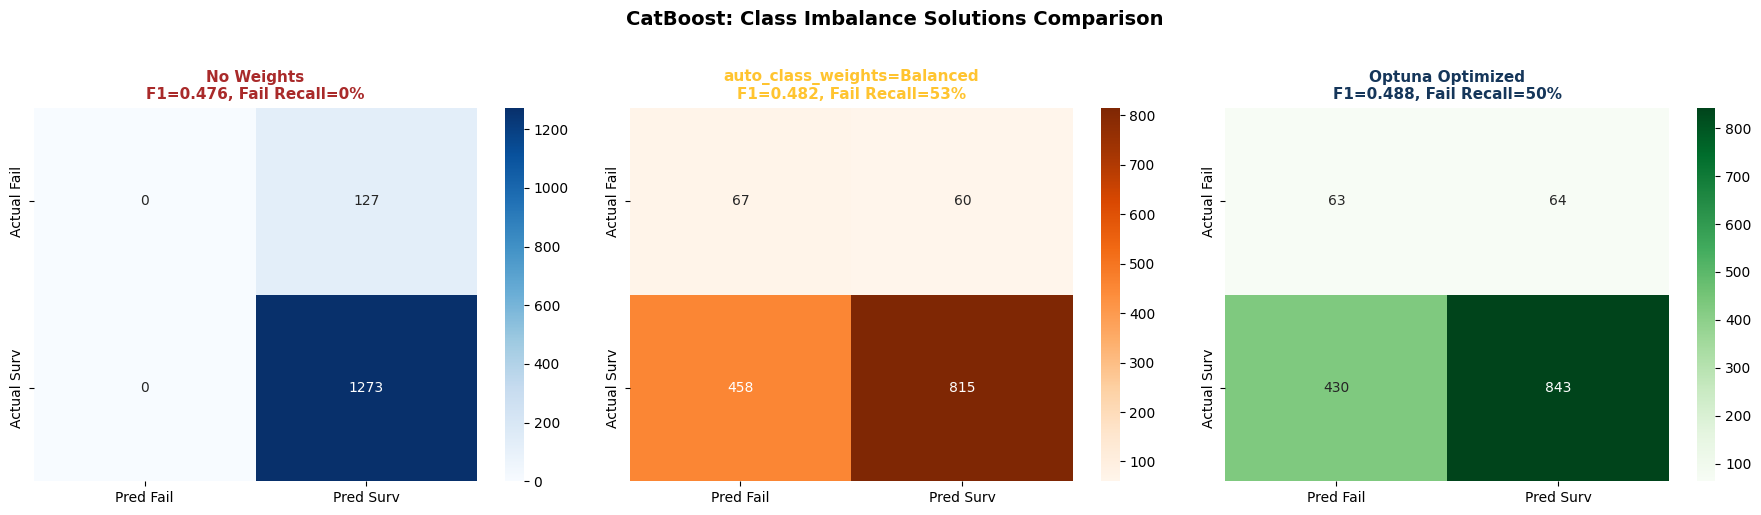

In [23]:
# =============================================================================
# 3-WAY CONFUSION MATRIX COMPARISON
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---- 1. No Weights ----
cm_no_weights = confusion_matrix(y_val, y_pred_cat)
sns.heatmap(cm_no_weights, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred Fail', 'Pred Surv'],
            yticklabels=['Actual Fail', 'Actual Surv'])
axes[0].set_title(f'No Weights\nF1={f1_macro_cat:.3f}, Fail Recall={recall_failure_cat*100:.0f}%', 
                  fontweight='bold', fontsize=11, color=COLORS['crimson_blaze'])

# ---- 2. Balanced ----
cm_balanced = confusion_matrix(y_val, y_pred_balanced)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Pred Fail', 'Pred Surv'],
            yticklabels=['Actual Fail', 'Actual Surv'])
axes[1].set_title(f'auto_class_weights=Balanced\nF1={f1_macro_balanced:.3f}, Fail Recall={recall_failure_balanced*100:.0f}%', 
                  fontweight='bold', fontsize=11, color=COLORS['periospot_yellow'])

# ---- 3. Optuna Optimized ----
cm_opt = confusion_matrix(y_val, y_pred_opt)
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Pred Fail', 'Pred Surv'],
            yticklabels=['Actual Fail', 'Actual Surv'])
axes[2].set_title(f'Optuna Optimized\nF1={f1_macro_opt:.3f}, Fail Recall={recall_failure_opt*100:.0f}%', 
                  fontweight='bold', fontsize=11, color=COLORS['periospot_blue'])

plt.suptitle('CatBoost: Class Imbalance Solutions Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/cat_optuna_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


In [24]:
# =============================================================================
# COMPREHENSIVE COMPARISON TABLE
# =============================================================================

comparison_data = {
    'Model': [
        'CatBoost (no weights)',
        'CatBoost (Balanced)',
        'CatBoost (Optuna)'
    ],
    'ROC-AUC': [roc_auc_cat, roc_auc_balanced, roc_auc_opt],
    'PR-AUC': [pr_auc_cat, pr_auc_balanced, pr_auc_opt],
    'F1 (Macro)': [f1_macro_cat, f1_macro_balanced, f1_macro_opt],
    'Accuracy': [accuracy_cat, accuracy_balanced, accuracy_opt],
    'Recall (Failure)': [recall_failure_cat, recall_failure_balanced, recall_failure_opt],
    'Recall (Survival)': [recall_survival_cat, recall_survival_balanced, recall_survival_opt]
}

comparison_df = pd.DataFrame(comparison_data)

print("=" * 90)
print("CATBOOST MODEL COMPARISON")
print("=" * 90)
print(comparison_df.to_string(index=False))
print("=" * 90)

# Identify best model (highest failure recall among models with reasonable F1)
best_model = comparison_df.loc[comparison_df['Recall (Failure)'].idxmax()]
print(f"\n🏆 Best model for detecting at-risk implants: {best_model['Model']}")
print(f"   Failure Recall: {best_model['Recall (Failure)']*100:.1f}%")
print(f"   F1 (Macro): {best_model['F1 (Macro)']:.4f}")


CATBOOST MODEL COMPARISON
                Model  ROC-AUC   PR-AUC  F1 (Macro)  Accuracy  Recall (Failure)  Recall (Survival)
CatBoost (no weights) 0.592401 0.936877    0.476244  0.909286          0.000000           1.000000
  CatBoost (Balanced) 0.608780 0.937262    0.482183  0.630000          0.527559           0.640220
    CatBoost (Optuna) 0.600126 0.933560    0.488310  0.647143          0.496063           0.662215

🏆 Best model for detecting at-risk implants: CatBoost (Balanced)
   Failure Recall: 52.8%
   F1 (Macro): 0.4822


---

### 5. Save Results


In [25]:
# =============================================================================
# SAVE OPTIMIZED CATBOOST RESULTS
# =============================================================================

results_cat_optimized = {
    "model": "CatBoost (Optuna Optimized)",
    "roc_auc": float(roc_auc_opt),
    "pr_auc": float(pr_auc_opt),
    "accuracy": float(accuracy_opt),
    "f1_macro": float(f1_macro_opt),
    "recall_failure": float(recall_failure_opt),
    "recall_survival": float(recall_survival_opt),
    "hyperparameters": study.best_params,
    "optuna_trials": len(study.trials),
    "optuna_best_cv_score": float(study.best_value),
    "native_categorical_features": cat_features
}

with open('../results/catboost_optuna_results.json', 'w') as f:
    json.dump(results_cat_optimized, f, indent=2)

print("✅ Optimized CatBoost results saved to results/catboost_optuna_results.json")
print(f"\nSaved metrics:")
print(f"  - ROC-AUC:          {results_cat_optimized['roc_auc']:.4f}")
print(f"  - PR-AUC:           {results_cat_optimized['pr_auc']:.4f}")
print(f"  - F1 (Macro):       {results_cat_optimized['f1_macro']:.4f}")
print(f"  - Recall (Failure): {results_cat_optimized['recall_failure']:.4f}")


✅ Optimized CatBoost results saved to results/catboost_optuna_results.json

Saved metrics:
  - ROC-AUC:          0.6001
  - PR-AUC:           0.9336
  - F1 (Macro):       0.4883
  - Recall (Failure): 0.4961


---

### ✅ CatBoost Training Complete!

**Key Learnings:**

1. **CatBoost Native Categorical Handling:**
   - Pass `cat_features` parameter with list of categorical column names
   - Keeps categorical data as strings (NOT one-hot encoded)
   - Uses target encoding internally (more powerful!)

2. **Class Imbalance Handling in CatBoost:**
   - `auto_class_weights='Balanced'` - Automatic class weights
   - `auto_class_weights='SqrtBalanced'` - Softer version

3. **Optuna Hyperparameter Tuning:**
   - Searched across 50 trials to optimize F1 (Macro)
   - Key parameters: iterations, depth, learning_rate, l2_leaf_reg
   - Cross-validation ensures robust hyperparameter selection

**Next Steps:** 
- Compare all models in `07_Submission_Generation.ipynb`
- Generate final predictions with the best model
